In [1]:
from hybri import Hybrizone, HybriParams, PolarPoint, AirData, AngleMode, CoordMode, BuildMode, CurveMode, InterpolationDomain
import librosa as lb
import numpy as np
import pyaudio as pa
# import time
# from collections import deque
# import scipy
# from threading import Thread, Event
# from queue import Queue
# import hashlib
# from concurrent.futures import ThreadPoolExecutor
# from numpy.typing import NDArray


In [2]:

HRIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/HRIR-KEMAR_DATASET.h5"
RIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/RIR-MIT_SURVEY.h5"
AUDIO_PATH = "/Users/pm/AcaHub/AudioSamples/suzanne_mono.wav"

CHUNK = 1024
SR = 44100
CHANNELS = 2

PARAMS = HybriParams(
        hrir_database=HRIR_PATH, 
        rir_database=RIR_PATH, 
        coord_mode=CoordMode.REGULAR, 
        interp_domain=InterpolationDomain.FREQUENCY,
        build_mode=BuildMode.LINEAR,
        chunk_size=CHUNK,
        interpolation_neighs=3
)

SIG, _ = lb.load(AUDIO_PATH, sr=SR)
SIG_LIMIT = len(SIG)

In [3]:
h = Hybrizone(params=PARAMS)

air_conditions = AirData(temperature=20, humidity=0.5, pressure=101325.0)
h.imposed_air_conditions(air_data=air_conditions)
h.set_rirs(rir1=1, rir2=90, smooth_factor=0.1)

In [ ]:
h.start_space_data_process()

p = pa.PyAudio()
stream = p.open(format=pa.paFloat32, channels=2, rate=SR, output=True, frames_per_buffer=CHUNK)
stream.start_stream()

mark = 0
while True:
    
    if mark >= SIG_LIMIT:
        h.close()
        break
    
    end = min(mark + CHUNK, SIG_LIMIT - 1)
    frame = SIG[mark:end]
    
    pos = PolarPoint(rho=1.7, phi=20, theta=60, opt=AngleMode.DEGREE)
    h.set_position(position=pos)
    h.set_morph_data(direction=0.5, morph_curve=CurveMode.SIGMOID)
    
    kernels = h.get_rir_and_hrir()
    if kernels is not None:
        convolved_frame = h.process_frame(frame=frame, kernels=kernels)
        stream.write(convolved_frame.tobytes())
        
        mark += CHUNK
    else:
        stream.write(np.zeros((CHUNK, 2), dtype=np.float32).tobytes())
        
while True:
    try:
        pass
    except KeyboardInterrupt:
        print("[INFO] Process blocked by user!")
        break

stream.stop_stream()
stream.close()
p.terminate()

In [4]:
h.start_space_data_process()
pos = PolarPoint(rho=20, phi=10, theta=60, opt=AngleMode.DEGREE)
h.set_position(position=pos)
h.set_morph_data(direction=0.5, morph_curve=CurveMode.SIGMOID)
kernels = h.get_rir_and_hrir()
print(kernels)
# h.close()


[INFO] SPACE PROCESS STARTED!
[WARNING] Empty cache!
[WARNING] Searching pos...


In [15]:
kernels.hrir

array([[-9.97015323e-07, -2.45009160e-10],
       [ 1.17748644e-07,  3.68721266e-09],
       [-8.21179220e-08, -4.26366593e-09],
       ...,
       [-7.36341588e-05, -3.27207838e-06],
       [-7.64248829e-05, -1.20739442e-06],
       [-9.64190651e-05,  3.72388343e-07]])

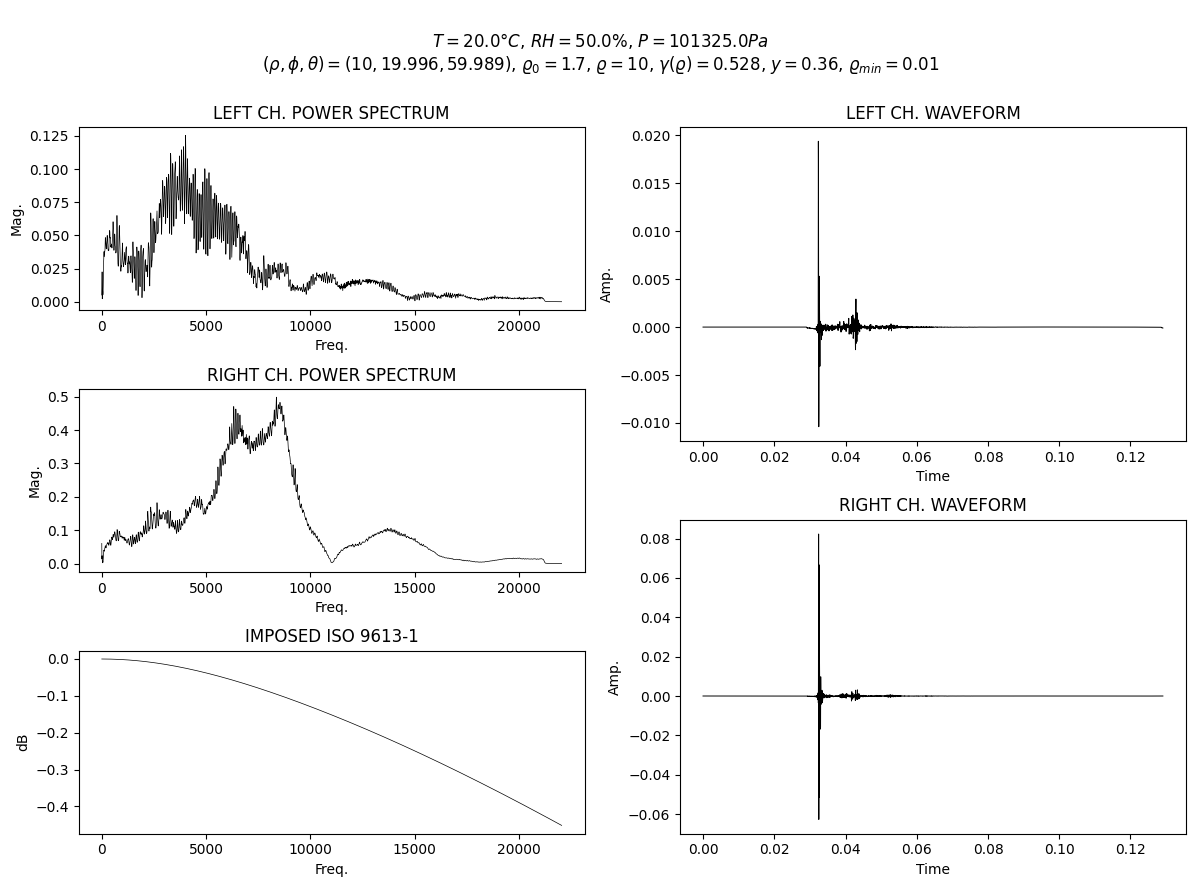

In [16]:
h.display_hrir(hrir=kernels.hrir, title="")

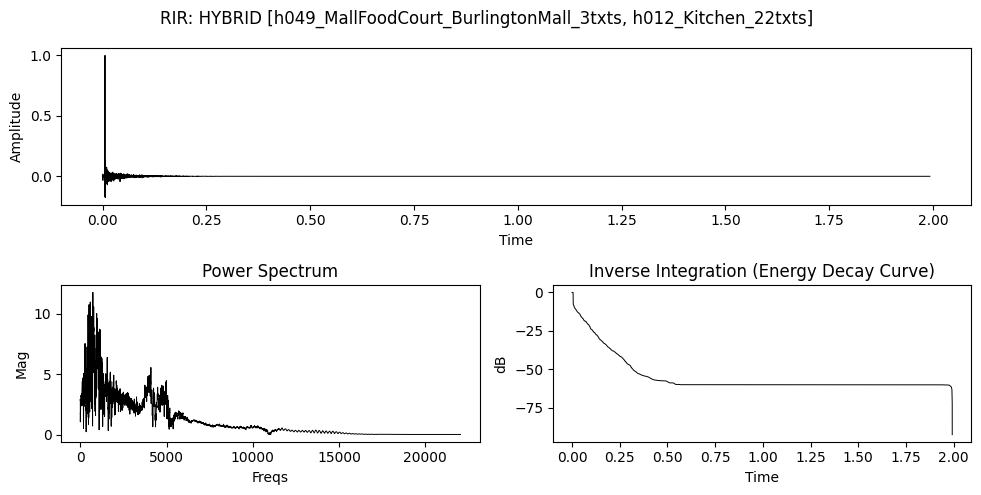

In [7]:
h.display_rir(rir=kernels.rir, title="HYBRID [h049_MallFoodCourt_BurlingtonMall_3txts, h012_Kitchen_22txts]")

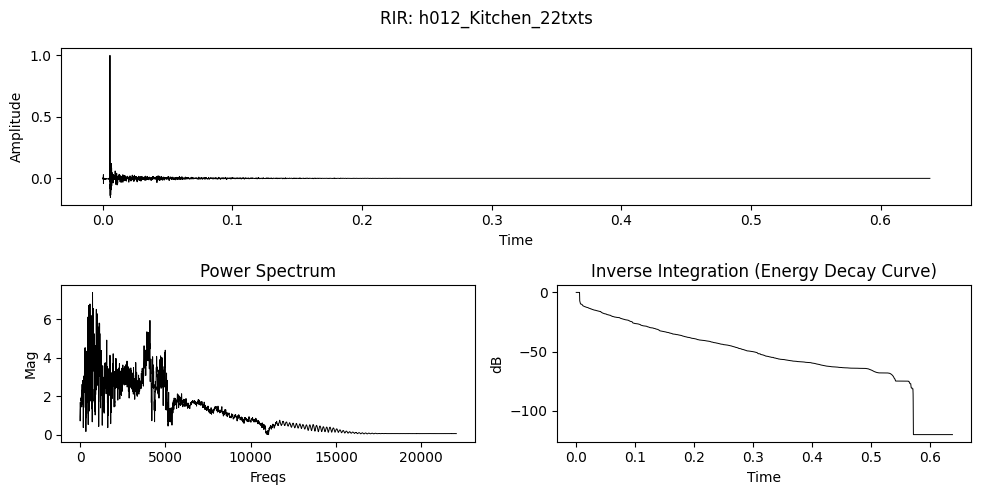

In [8]:
h.display_rir(rir=90)

In [9]:
h.get_rir_key(rir_index=1)

'h049_MallFoodCourt_BurlingtonMall_3txts'

In [10]:
h.get_rir_key(rir_index=90)

'h012_Kitchen_22txts'